In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
from google.colab import files
import pandas as pd

# Upload *ocr_results*
uploaded_csv = files.upload()

# Get the file name (first key in the uploaded dictionary)
file1 = list(uploaded_csv.keys())[0]

# Load the CSV file
ocr_results = pd.read_csv(file1, encoding='ISO-8859-1')

# Display first few rows
ocr_results.head()

Saving ocr_results.csv to ocr_results (1).csv


,Filename,DetectedText,X,Y
0,1.jpeg,i,1343,11
1,1.jpeg,a,1410,466
2,1.jpeg,ec-2022920AM,1412,556
3,10.png,100,1007,116
4,10.png,cmis,1013,196


In [8]:
import pandas as pd
import numpy as np
import os

# Use your loaded OCR dataframe
df = ocr_results.copy()  # Or load from CSV if needed

# Normalize text
df['DetectedText'] = df['DetectedText'].str.lower().str.strip()

# Dictionary-based corrections
ocr_corrections = {
    'cmis': 'cm/s',
    'cms': 'cm/s',
    'ems': 'cm/s',
    'cms': 'cm/s',
    'emis': 'cm/s',
    'Mc': 'cm/s',
    'Ho': 'cm/s',
    'omis': 'cm/s',
    'mis': 'cm/s',
    '-cm/s': 'cm/s',
    '-cmis': 'cm/s',
    'lcmis': 'cm/s',
    'lemis': 'cm/s',

    'm/s': 'cm/s',
    '-m/s': 'cm/s',

    # '300.': '300',
    # '..300': '300',
    # '-300': '300',
    # '--300': '300',
    # '3.0': '300',
    # '-3.0': '300'


}

# Apply corrections
df['CleanedText'] = df['DetectedText'].replace(ocr_corrections)

# Convert anything with a '3' and a digit into '300'
df['CleanedText'] = df['CleanedText'].apply(lambda x: '300' if '3' in x and any(char.isdigit() for char in x) else x)

# Filter out super-short or empty junk strings
df = df[df['CleanedText'].str.len() > 2]

# Filter down to just the needed values
df_filtered = df[df['CleanedText'].isin(['cm/s','m/s', '300'])]

# Compute distances
results = []

for filename, group in df_filtered.groupby('Filename'):
    y_unit = group[group['CleanedText'].isin(['cm/s', 'm/s'])]['Y']
    y_300 = group[group['CleanedText'] == '300']['Y']

    if not y_unit.empty and not y_300.empty:
        unit_label = group[group['CleanedText'].isin(['cm/s', 'm/s'])]['CleanedText'].values[0]
        unit_y = y_unit.values[0]
        y_300_val = y_300.values[0]
        pixel_dist = abs(unit_y - y_300_val)

        results.append({
            'Filename': filename,
            'UnitLabel': unit_label,
            'UnitY': unit_y,
            '300Y': y_300_val,
            'PixelDistance': pixel_dist
        })
    else:
        print(f"⚠️ Skipped: {filename} (missing '300' or unit label)")

# Create output DataFrame
results_df = pd.DataFrame(results)

# Ensure directory exists
output_dir = "/content/drive/My Drive/4th Year/DS 4002/Project 3"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "cm_m_300_distances.csv")

# Save it
results_df.to_csv(output_path, index=False)

print("✅ Done! Cleaned distances saved to:", output_path)


⚠️ Skipped: 14.jpeg (missing '300' or unit label)
⚠️ Skipped: 17.png (missing '300' or unit label)
⚠️ Skipped: 18.png (missing '300' or unit label)
⚠️ Skipped: 19.png (missing '300' or unit label)
⚠️ Skipped: 20.png (missing '300' or unit label)
⚠️ Skipped: 27.png (missing '300' or unit label)
⚠️ Skipped: 29.png (missing '300' or unit label)
⚠️ Skipped: 3.png (missing '300' or unit label)
⚠️ Skipped: 32.png (missing '300' or unit label)
⚠️ Skipped: 33.png (missing '300' or unit label)
⚠️ Skipped: 36.png (missing '300' or unit label)
⚠️ Skipped: 4.jpeg (missing '300' or unit label)
⚠️ Skipped: 5.jpeg (missing '300' or unit label)
⚠️ Skipped: 7.jpeg (missing '300' or unit label)
⚠️ Skipped: 9.png (missing '300' or unit label)
✅ Done! Cleaned distances saved to: /content/drive/My Drive/4th Year/DS 4002/Project 3/cm_m_300_distances.csv


In [9]:
# Total number of unique images processed
total_images = ocr_results['Filename'].nunique()

# Number of images where you successfully found both cm/s or m/s AND a 300 label
successful_images = results_df['Filename'].nunique()

# Accuracy / hit rate
hit_rate = successful_images / total_images

# Print it out
print(f"📦 Total images processed: {total_images}")
print(f"✅ Successful detections (with both unit & 300): {successful_images}")
print(f"🎯 Hit rate: {hit_rate:.2%}")


📦 Total images processed: 40
✅ Successful detections (with both unit & 300): 19
🎯 Hit rate: 47.50%


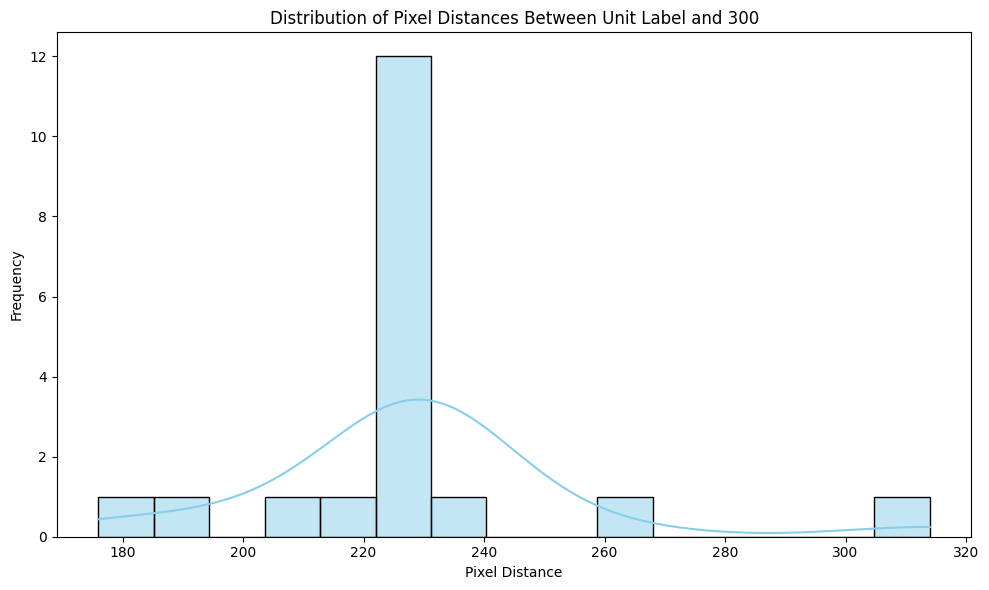

📏 Average Pixel Distance: 229.16 pixels


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of Pixel Distances
plt.figure(figsize=(10, 6))
sns.histplot(results_df['PixelDistance'], bins=15, kde=True, color='skyblue')
plt.title('Distribution of Pixel Distances Between Unit Label and 300')
plt.xlabel('Pixel Distance')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.show()

# Calculate Average Pixel Distance
average_distance = results_df['PixelDistance'].mean()
print(f"📏 Average Pixel Distance: {average_distance:.2f} pixels")


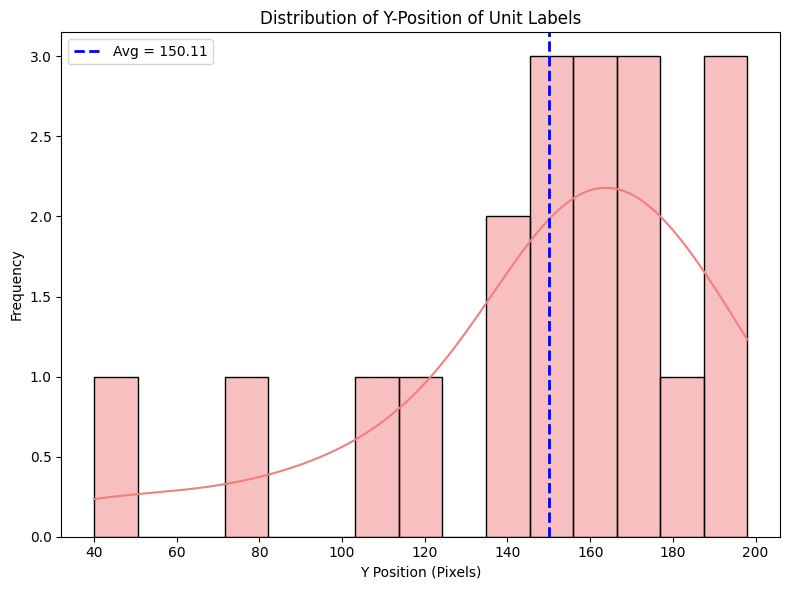

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average Y position
avg_unit_y = results_df['UnitY'].mean()

# Plot the histogram
plt.figure(figsize=(8, 6))
sns.histplot(results_df['UnitY'], bins=15, kde=True, color='lightcoral')

# Add a vertical line for the average
plt.axvline(avg_unit_y, color='blue', linestyle='--', linewidth=2, label=f'Avg = {avg_unit_y:.2f}')

# Labels and layout
plt.title('Distribution of Y-Position of Unit Labels')
plt.xlabel('Y Position (Pixels)')
plt.ylabel('Frequency')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()
